In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.io import wavfile
import scipy.signal
import torch


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 20
})

In [3]:
def load_lpcnet_features(feature_file, version=2):
    if version == 2 or version == 3:
        layout = {
            'cepstrum': [0,18],
            'periods': [18, 19],
            'pitch_corr': [19, 20],
            'lpc': [20, 36]
            }
        frame_length = 36

    elif version == 1:
        layout = {
            'cepstrum': [0,18],
            'periods': [36, 37],
            'pitch_corr': [37, 38],
            'lpc': [39, 55],
            }
        frame_length = 55
    else:
        raise ValueError(f'unknown feature version: {version}')


    raw_features = torch.from_numpy(np.fromfile(feature_file, dtype='float32'))
    raw_features = raw_features.reshape((-1, frame_length))

    features = torch.cat(
        [
            raw_features[:, layout['cepstrum'][0]   : layout['cepstrum'][1]],
            raw_features[:, layout['pitch_corr'][0] : layout['pitch_corr'][1]]
        ],
        dim=1
    )

    lpcs = raw_features[:, layout['lpc'][0]   : layout['lpc'][1]]
    if version < 3:
        periods = (0.1 + 50 * raw_features[:, layout['periods'][0] : layout['periods'][1]] + 100).long()
    else:
        periods = torch.round(torch.clip(256./2**(raw_features[:, layout['periods'][0] : layout['periods'][1]] + 1.5), 32, 256)).long()

    return {'features' : features, 'periods' : periods, 'lpcs' : lpcs}

In [4]:
lpcnet_features = load_lpcnet_features('lp/features.f32')

features = lpcnet_features['features'].numpy()
periods = lpcnet_features['periods'].squeeze(-1).numpy()
lpcs = lpcnet_features['lpcs'].numpy()

x = np.fromfile('data/critical_3.pcm', dtype=np.int16).astype(np.float32) / 2**15
x = np.concatenate((np.zeros(80), x, np.zeros(320)))
x_preemph = x.copy()
x_preemph[1:] -= 0.85 * x_preemph[:-1]

num_frames = features.shape[0]
x = x[:160 * num_frames]
x_preemph = x_preemph[:160 * num_frames]

In [5]:
def stp(A, alpha=0.8, beta=0.5):
    A_num = A * (beta ** np.arange(len(A)))
    A_den = A * (alpha ** np.arange(len(A)))
    
    return A_num, A_den

In [10]:
frame_idx = 31

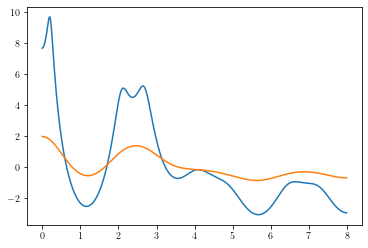

In [11]:

A = np.concatenate((np.ones(1), lpcs[frame_idx]))
A_num, A_den = stp(A)
w, h = scipy.signal.freqz([1], A, fs=16000)
w, h_stp = scipy.signal.freqz(A_num, A_den, fs=16000)
plt.plot(w/1000, 10*np.log10(np.abs(h)))
plt.plot(w/1000, 10*np.log10(np.abs(h_stp)))

In [12]:
x_frame = x_preemph[frame_idx * 160 - 80: (frame_idx + 1) * 160 + 80]

window = scipy.signal.get_window('hamming', 320)
spec = np.fft.fft(x_frame, n=1024)

log_mag = 10*np.log10(np.abs(spec[:512]) + 1e-6)

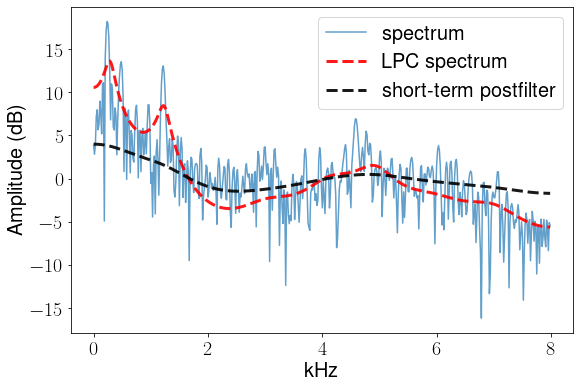

In [61]:
fig = plt.figure(figsize=(9, 6))

plt.plot(w/1000, log_mag - log_mag.mean(), alpha=0.7, label='spectrum')
plt.plot(w/1000, 10*np.log10(np.abs(h)), "r--", label='LPC spectrum', linewidth=3, alpha=0.9)
plt.plot(w/1000, 10*np.log10(np.abs(h_stp)), "k--", label='short-term postfilter', linewidth=3, alpha=0.9)
plt.legend()
plt.xlabel('kHz')
plt.ylabel('Amplitude (dB)')
plt.show()
fig.savefig('plots/short_term_postfilter.png')

In [62]:
periods[frame_idx]

p = int(periods[frame_idx])
ltp_num = np.zeros(p+1)
ltp_den = np.zeros(p+1)

ltp_num[0] = ltp_den[0] = 1
ltp_num[p] = 0.25
ltp_den[p] = -0.25

w, h_ltp = scipy.signal.freqz(ltp_num, ltp_den, fs=16000)

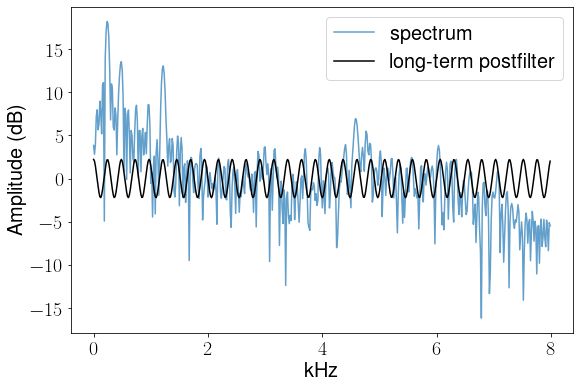

In [63]:
fig = plt.figure(figsize=(9, 6))
plt.plot(w/1000, log_mag - log_mag.mean(), alpha=0.7, label='spectrum')
plt.plot(w/1000, 10*np.log10(np.abs(h_ltp)), "k", alpha=1, label='long-term postfilter', linewidth=1.5)
plt.legend()
plt.xlabel('kHz')
plt.ylabel('Amplitude (dB)')
plt.show()
fig.savefig('plots/long_term_postfilter.png')